## Pneumonia Detection from Chest X-ray Images

In this notebook, a `Convolutional Neural Network (CNN)` has been developed and trained to select the presence of `pneumonia` disease by analyzing chest X-ray images.

This is a `binary classification` problem where the outcome is either a person has `pneumonia` disease or not (`normal` condition).

This model is built from scratch, i.e. not relying on transfer learning approaches (pre-trained models).

To increase performance metrics I 
- increased the number of epochs
- apply data augmentation

### Import Libraries

In [31]:
import os

import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, SeparableConv2D, \
    Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from datetime import datetime


### Configurations

In [32]:
MODEL_LOC = 'model_best_pneumonia_detection_cnn_model.h5'
DATA_DIR = 'chest_xray/'
TRAINING_DATA_DIR = 'chest_xray/train/'
TEST_DATA_DIR = 'chest_xray/test/'
VAL_DATA_DIR = 'chest_xray/val/'
DETECTION_CLASSES = ('NORMAL', 'PNEUMONIA')
BATCH_SIZE = 32
EPOCHS = 50 # original was 100

timestamp = datetime.now().strftime("%Y-%m-%d-%H-%M")
MODEL_FILE = f"model_{EPOCHS}_epochs_{timestamp}.h5"
print(MODEL_FILE)

model_50_epochs_2025-05-10-16-30.h5


### Exploratory Data Analysis (EDA)

In [33]:
import os

def count_images(directory_name, detection_class):
    return len(os.listdir(os.path.join(directory_name, detection_class)))

# # Define your directories

# Prepare counts
data = [
    ['Dataset Type', 'Normal', 'Pneumonia'],
    ['Training', count_images(TRAINING_DATA_DIR, 'NORMAL'), count_images(TRAINING_DATA_DIR, 'PNEUMONIA')],
    ['Test', count_images(TEST_DATA_DIR, 'NORMAL'), count_images(TEST_DATA_DIR, 'PNEUMONIA')],
    ['Validation', count_images(VAL_DATA_DIR, 'NORMAL'), count_images(VAL_DATA_DIR, 'PNEUMONIA')],
]

# Print table
col_widths = [max(len(str(row[i])) for row in data) for i in range(3)]

for row in data:
    print(f"{str(row[0]).ljust(col_widths[0])} | {str(row[1]).rjust(col_widths[1])} | {str(row[2]).rjust(col_widths[2])}")


Dataset Type | Normal | Pneumonia
Training     |   1341 |      3875
Test         |    234 |       390
Validation   |      8 |         8


As can be seen from the above data exploration, the data is highly imbalanced. That is, the number of images for `pneumonia` cases are much higher than the `normal` cases. However, this is expected in the medical data, as a person is advised to have the X-ray done if some symptoms are noticed and hence more likely to have the disease.

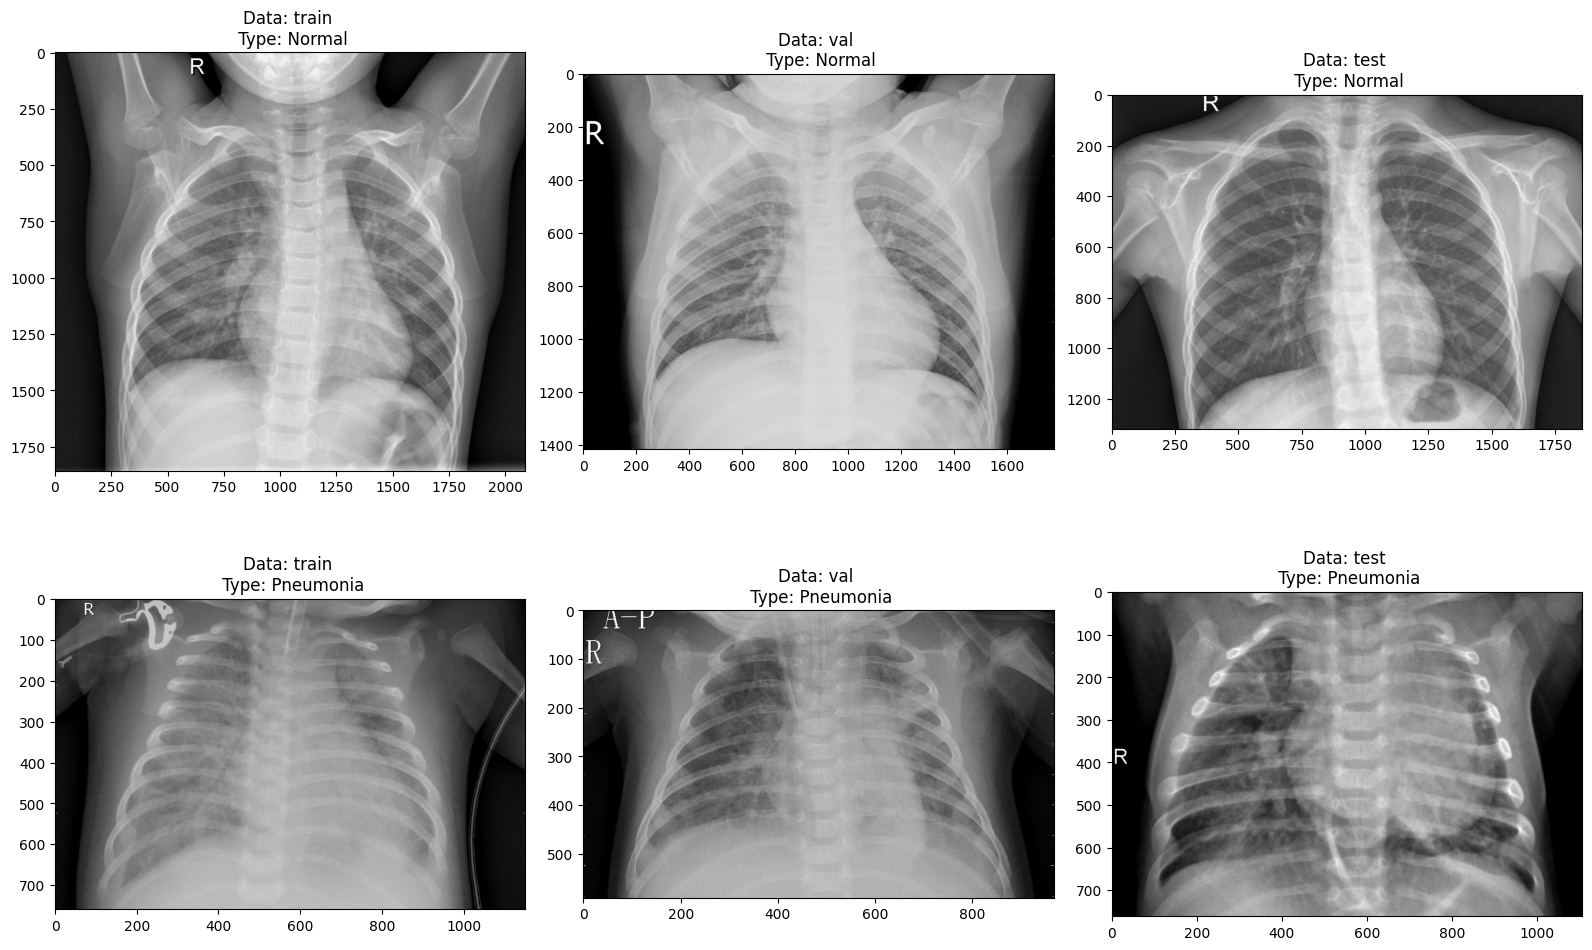

In [34]:
# Looking at one image per class in each dataset type
fig, ax = plt.subplots(2, 3, figsize = (16, 10))
ax = ax.ravel()
plt.tight_layout()

for i, subdir in enumerate(['train', 'val', 'test']):
    image_path = DATA_DIR + subdir
    ax[i].imshow(plt.imread(image_path + '/NORMAL/' + os.listdir(image_path + '/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Data: {} \n Type: Normal'.format(subdir), fontsize = 12)
    ax[i+3].imshow(plt.imread(image_path + '/PNEUMONIA/' + os.listdir(image_path + '/PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('Data: {} \n Type: Pneumonia'.format(subdir), fontsize = 12)

### Prepare Data

In [35]:
# data generator on training dataset, data augmentation applied
train_datagen = ImageDataGenerator(rescale=1.0 / 255.0,
                                   shear_range=0.2,
                                   vertical_flip=True,
                                   rotation_range=10,
                                   zoom_range=0.3)

# preprocessing the training dataset
training_dataset = train_datagen.flow_from_directory(TRAINING_DATA_DIR,
                                                     classes=DETECTION_CLASSES,
                                                     shuffle=True,
                                                     batch_size=BATCH_SIZE,
                                                     target_size=(224, 224))



# data generator on test dataset, data augmentation not applied
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# preprocessing the test dataset 
test_dataset = test_datagen.flow_from_directory(TEST_DATA_DIR,
                                                classes=DETECTION_CLASSES,
                                                shuffle=False,
                                                batch_size=BATCH_SIZE,
                                                target_size=(224, 224))



# data generator on validation dataset, data augmentation not applied
val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# preprocessing the validation dataset
val_dataset = val_datagen.flow_from_directory(VAL_DATA_DIR,
                                               classes=DETECTION_CLASSES,
                                               shuffle=False,
                                               batch_size=BATCH_SIZE,
                                               target_size=(224, 224))

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [36]:
# printing the assigned indices for sanity check
print(f'class indices:  {training_dataset.class_indices}')

class indices:  {'NORMAL': 0, 'PNEUMONIA': 1}


### Build `CNN` Model

The following model consists of five `convolution` blocks where after each block, a pooling layer (`max pooling`) is added. The `flattening` layer after the last convolution block prepares the input to be fed into the fully connected layers. In each fully connected layer, `dense` method is used to add a hidden layer where `units` represent the number of nodes/neurons in that layer. The last fully connected layer has two nodes representing the two classes - `pneumonia` and `normal` where the `softmax` activation function (as the two cases are mutually exclusive case) is used. One can also use in this case the `sigmoid` activation function with one unit in the output layer with `binary cross-entropy` loss. 

In [37]:
cnn_model = Sequential()

# First Block of CNN
cnn_model.add(Conv2D(16, (3, 3), padding='same', input_shape=(224, 224, 3), activation='relu'))
cnn_model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))

#  Second Block of CNN
cnn_model.add(SeparableConv2D(32, (3, 3), padding='same', activation='relu'))
cnn_model.add(SeparableConv2D(32, (3, 3), padding='same', activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D((2, 2)))

#  Third Block of CNN
cnn_model.add(SeparableConv2D(64, (3, 3), padding='same', activation='relu'))
cnn_model.add(SeparableConv2D(64, (3, 3), padding='same', activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D((2, 2)))

#  Fourth Block of CNN
cnn_model.add(SeparableConv2D(128, (3, 3), padding='same', activation='relu'))
cnn_model.add(SeparableConv2D(128, (3, 3), padding='same', activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Dropout(rate=0.2))

#  Fifth Block of CNN
cnn_model.add(SeparableConv2D(256, (3, 3), padding='same', activation='relu'))
cnn_model.add(SeparableConv2D(256, (3, 3), padding='same', activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Dropout(rate=0.2))

#  Flatten and Fully Connected Layer
cnn_model.add(Flatten())
cnn_model.add(Dense(units=512, activation='relu'))
cnn_model.add(Dropout(rate=0.7))
cnn_model.add(Dense(units=128, activation='relu'))
cnn_model.add(Dropout(rate=0.5))
cnn_model.add(Dense(units=64, activation='relu'))
cnn_model.add(Dropout(rate=0.3))

#  Softmax Classifier
cnn_model.add(Dense(units=2, activation='softmax'))

#  Display model
cnn_model.summary()

# compile model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

c:\Users\hi\Desktop\projects\python_projects\tutorial\tut_tensorflow\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 224, 224, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 224, 224, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_16                  │ (None, 112, 112, 32)        │             688 │
│ (SeparableConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_17                  │ (None, 112, 112, 32)        │           1,344 │
│ (SeparableConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 112, 112, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_18                  │ (None, 56, 56, 64)          │           2,400 │
│ (SeparableConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_19                  │ (None, 56, 56, 64)          │           4,736 │
│ (SeparableConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_20                  │ (None, 28, 28, 128)         │           8,896 │
│ (SeparableConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_21                  │ (None, 28, 28, 128)         │          17,664 │
│ (SeparableConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_22                  │ (None, 14, 14, 256)         │          34,1

 Total params: 6,639,778 (25.33 MB)

 Trainable params: 6,638,818 (25.33 MB)

 Non-trainable params: 960 (3.75 KB)

### Train `CNN` Model


In [38]:
# introducing callbacks
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           mode='min',
                           min_delta=0.001,
                           restore_best_weights=True)

checkpoint = ModelCheckpoint(filepath=MODEL_LOC,  # saves the 'best' model
                             monitor='val_loss',
                             save_best_only=True,
                             mode='min')

In [39]:
# fit the model
# 20 epoch took 45 minutes on CPU
# 50 epoch took 2.5 hrs on CPU

history = cnn_model.fit(training_dataset,
                        steps_per_epoch=len(training_dataset),
                        validation_data=val_dataset,
                        validation_steps=len(val_dataset),
                        epochs=EPOCHS,
                        callbacks=[early_stop, checkpoint],
                        verbose=1)

c:\Users\hi\Desktop\projects\python_projects\tutorial\tut_tensorflow\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7872 - loss: 0.4566  

163/163 ━━━━━━━━━━━━━━━━━━━━ 192s 1s/step - accuracy: 0.7875 - loss: 0.4560 - val_accuracy: 0.5000 - val_loss: 0.8440
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - accuracy: 0.8674 - loss: 0.2996 - val_accuracy: 0.5000 - val_loss: 0.9895
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8815 - loss: 0.2706  

163/163 ━━━━━━━━━━━━━━━━━━━━ 187s 1s/step - accuracy: 0.8815 - loss: 0.2706 - val_accuracy: 0.5000 - val_loss: 0.8070
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.8981 - loss: 0.2486 - val_accuracy: 0.5000 - val_loss: 0.8749
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.9040 - loss: 0.2441 - val_accuracy: 0.5000 - val_loss: 1.7764
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.9080 - loss: 0.2364 - val_accuracy: 0.5000 - val_loss: 1.2849
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.9065 - loss: 0.2284 - val_accuracy: 0.5000 - val_loss: 5.0025
Epoch 8/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.9169 - loss: 0.2086 - val_accuracy: 0.5000 - val_loss: 1.0359
Epoch 9/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.9194 - loss: 0.2062 - val_accuracy: 0.5000 - val_loss: 1.2065
Epoch 10/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.9272 - loss: 0.1893 - val_accuracy: 0.50

163/163 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.9306 - loss: 0.1924 - val_accuracy: 0.5000 - val_loss: 0.7982
Epoch 12/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9232 - loss: 0.1963  

163/163 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.9232 - loss: 0.1963 - val_accuracy: 0.6250 - val_loss: 0.6996
Epoch 13/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 192s 1s/step - accuracy: 0.9283 - loss: 0.1867 - val_accuracy: 0.5000 - val_loss: 1.8585
Epoch 14/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 187s 1s/step - accuracy: 0.9401 - loss: 0.1640 - val_accuracy: 0.5000 - val_loss: 1.2040
Epoch 15/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 175s 1s/step - accuracy: 0.9362 - loss: 0.1739 - val_accuracy: 0.5000 - val_loss: 1.4005
Epoch 16/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 175s 1s/step - accuracy: 0.9244 - loss: 0.2092 - val_accuracy: 0.4375 - val_loss: 0.7917
Epoch 17/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.9363 - loss: 0.1790 - val_accuracy: 0.5000 - val_loss: 5.8131
Epoch 18/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 179s 1s/step - accuracy: 0.9402 - loss: 0.1619 - val_accuracy: 0.6875 - val_loss: 0.9760
Epoch 19/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.9397 - loss: 0.1760 - val_accuracy

163/163 ━━━━━━━━━━━━━━━━━━━━ 179s 1s/step - accuracy: 0.9445 - loss: 0.1537 - val_accuracy: 0.7500 - val_loss: 0.6887
Epoch 22/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.9429 - loss: 0.1527 - val_accuracy: 0.5000 - val_loss: 0.7024
Epoch 23/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9420 - loss: 0.1648  

163/163 ━━━━━━━━━━━━━━━━━━━━ 187s 1s/step - accuracy: 0.9420 - loss: 0.1648 - val_accuracy: 0.6875 - val_loss: 0.6560
Epoch 24/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9504 - loss: 0.1530  

163/163 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.9504 - loss: 0.1530 - val_accuracy: 0.6250 - val_loss: 0.6490
Epoch 25/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.9377 - loss: 0.1674 - val_accuracy: 0.5000 - val_loss: 3.9209
Epoch 26/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.9478 - loss: 0.1432 - val_accuracy: 0.5000 - val_loss: 12.5365
Epoch 27/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9426 - loss: 0.1582  

163/163 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.9427 - loss: 0.1581 - val_accuracy: 0.8750 - val_loss: 0.3409
Epoch 28/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.9447 - loss: 0.1620 - val_accuracy: 0.5000 - val_loss: 8.6685
Epoch 29/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.9404 - loss: 0.1640 - val_accuracy: 0.5000 - val_loss: 1.4686
Epoch 30/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.9434 - loss: 0.1501 - val_accuracy: 0.5000 - val_loss: 2.7400
Epoch 31/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.9523 - loss: 0.1554 - val_accuracy: 0.5000 - val_loss: 0.8908
Epoch 32/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.9485 - loss: 0.1389 - val_accuracy: 0.5000 - val_loss: 13.8296
Epoch 33/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 193s 1s/step - accuracy: 0.9450 - loss: 0.1566 - val_accuracy: 0.6875 - val_loss: 1.0739
Epoch 34/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - accuracy: 0.9568 - loss: 0.1197 - val_accurac

# Note
When I ran for 50 epochs, it stopped after 37 epochs due to early stopping condition

In [40]:
# save the model
cnn_model.save(MODEL_FILE)  # creates a file 'model_20_epochs_time_stamp.h5' at the end

### Plot Training History

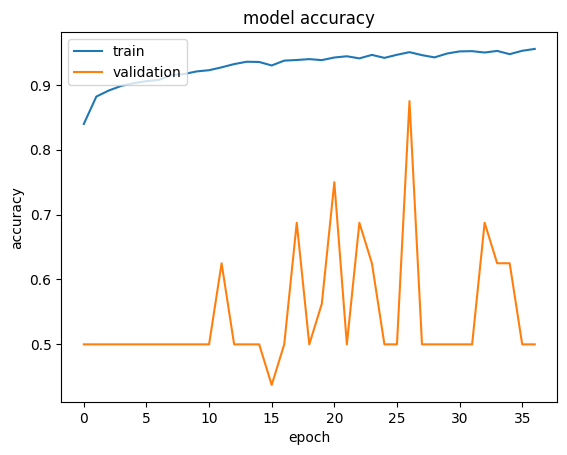

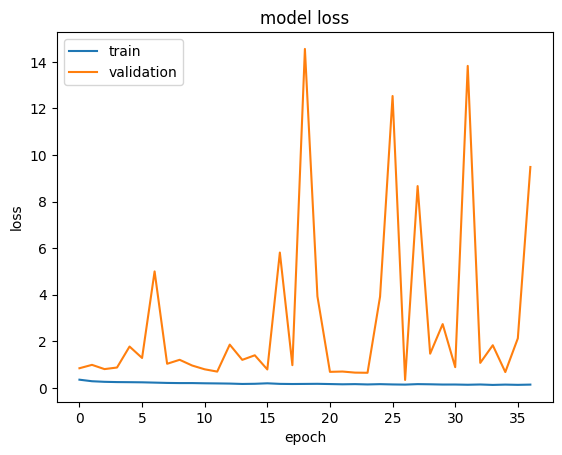

In [41]:
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Model Evaluation

### on test dataset

In [42]:
# load the trained CNN model
# cnn_model = load_model(MODEL_FILE) or  cnn_model = load_model(MODEL_LOC)

In [43]:
# storing the true classes of the test dataset
y_true = test_dataset.classes

# predicting the classes of the test dataset
y_pred = cnn_model.predict(test_dataset, steps=len(test_dataset), verbose=1)

# Storing the predicted probability
y_pred_prob = y_pred[:, 1]

# Storing the binary classes for the predictions
y_pred_binary = y_pred_prob > 0.5

20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 401ms/step 


In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, \
classification_report, roc_auc_score, roc_curve

In [45]:
# confusion matrix for test dataset 
print('\nConfusion Matrix for Test Dataset\n -------------------------')
cm = confusion_matrix(y_true, y_pred_binary)
print(cm)


Confusion Matrix for Test Dataset
 -------------------------
[[196  38]
 [ 19 371]]


Text(0.5, 1.0, 'Confusion Matrix for Test Dataset')

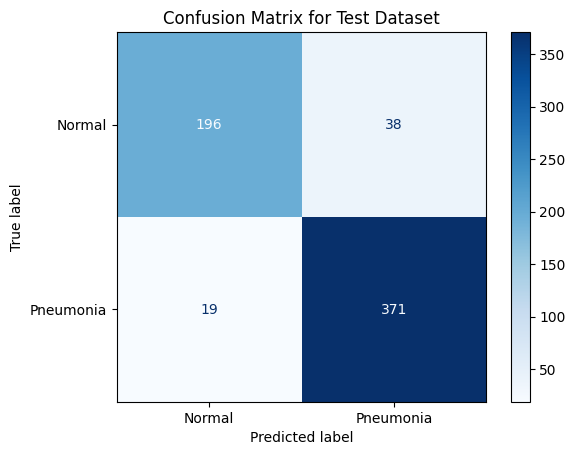

In [46]:
cm_display = ConfusionMatrixDisplay(cm, display_labels=['Normal', 'Pneumonia'])
cm_display.plot(cmap = 'Blues')
plt.title('Confusion Matrix for Test Dataset')

In [47]:
# classification report
# accuracy: (tp + tn) / (p + n)
# precision tp / (tp + fp)
# recall: tp / (tp + fn)
# f1_score: 2 tp / (2 tp + fp + fn)
print('\nClassification Report\n -------------------------')
print(classification_report(y_true, y_pred_binary))


Classification Report
 -------------------------
              precision    recall  f1-score   support

           0       0.91      0.84      0.87       234
           1       0.91      0.95      0.93       390

    accuracy                           0.91       624
   macro avg       0.91      0.89      0.90       624
weighted avg       0.91      0.91      0.91       624



In [48]:
# ROC AUC
auc = roc_auc_score(y_true, y_pred_prob)
print(f'ROC AUC (Test Dataset) {auc:.2}')


ROC AUC (Test Dataset) 0.95


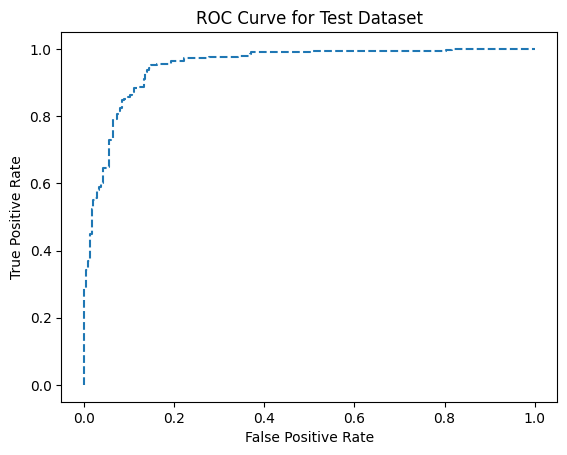

In [49]:
# calculate roc curves
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)

# plot the roc curve for the model
plt.figure()
plt.plot(fpr, tpr, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Test Dataset')
plt.show()

# Observation
Following is the stats I obtained when I ran for 20 and 50 epochs:

**1) Stats on 20 epochs**

```
Confusion Matrix for Test Dataset
 -------------------------
[[186  48]
 [ 19 371]]


Classification Report
 -------------------------
              precision    recall  f1-score   support

           0       0.91      0.79      0.85       234
           1       0.89      0.95      0.92       390

    accuracy                           0.89       624
   macro avg       0.90      0.87      0.88       624
weighted avg       0.89      0.89      0.89       624

-------------------------------

ROC AUC (Test Dataset) 0.95
```

**2) Stats on 50 epochs**

```
Confusion Matrix for Test Dataset
 -------------------------
[[196  38]
 [ 19 371]]


Classification Report
 -------------------------
              precision    recall  f1-score   support

           0       0.91      0.84      0.87       234
           1       0.91      0.95      0.93       390

    accuracy                           0.91       624
   macro avg       0.91      0.89      0.90       624
weighted avg       0.91      0.91      0.91       624

----------------
ROC AUC (Test Dataset) 0.95
```


### on validation dataset

In [50]:
# storing the true classes of the test dataset
y_true_val = val_dataset.classes

# predicting the classes of the test dataset
y_pred_val = cnn_model.predict(val_dataset, steps=len(val_dataset), verbose=1)

# Storing the predicted probability
y_pred_val_prob = y_pred_val[:, 1]

# Storing the binary classes for the predictions
y_pred_val_binary = y_pred_val_prob > 0.5

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step



Confusion Matrix for Validation Dataset
 -------------------------
[[7 1]
 [1 7]]


Text(0.5, 1.0, 'Confusion Matrix for Validation Dataset')

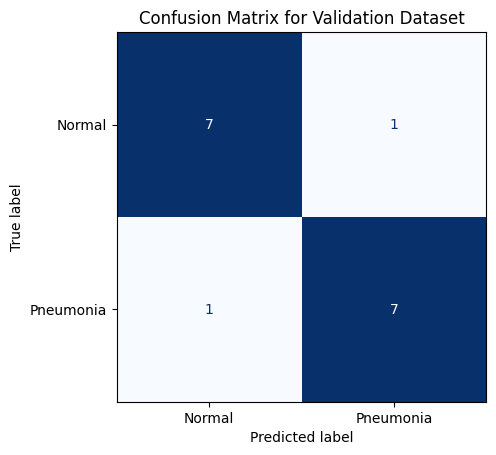

In [51]:
# confusion matrix for validation dataset 
print('\nConfusion Matrix for Validation Dataset\n -------------------------')
cm_val = confusion_matrix(y_true_val, y_pred_val_binary)
print(cm_val)

cm_display_val = ConfusionMatrixDisplay(cm_val, display_labels=['Normal', 'Pneumonia'])
cm_display_val.plot(cmap='Blues', colorbar=False)
plt.title('Confusion Matrix for Validation Dataset')